In [1]:
import pandas as pd
import os
from NLP_LLIS_files.lesson_selection_functions import *
import numpy as np
from keras import backend as K
datasheet_path = os.path.join(os.getcwd(),'LLIS datasheets','')
from nltk.corpus import stopwords
import string
import matplotlib.pyplot as plt
stopwords = stopwords.words('english')

In [2]:
topic_stopwords =   ["ames","armstrong","glenn","goddard","katherine","johnson",
                    "jpl","kennedy","langley","marshall","michoud","nasa","plum",
                    "brook","stennis","wallops","white","sands","sand","sandusky",
                    "ohio","cleveland","fairmont","west","virginia","greenbelt",
                    "maryland","virginia","washington","hampton","florida",
                    "huntsville","alabama","mississippi","orleans","louisiana",
                    "houston","texas","las","cruces","mexico","dryden","edwards",
                    "california","pasadena","moffett","field","york","albuquerque",
                    "robert","moscow","sofia", "january", "february", "march", 
                    "april", "may","june", "july", "august", "september", "october", 
                    "november", "december", "csoc", "gsfc", "cofr", "keyword",
                    "germany", "russia", "inch", "meter", "usml", "morning",
                    "also", "lesson", "learn", "lockheed", "martin", "northrop", "grumman",
                    "determine", "pick", "canoga", "park", "william", "think", "please",
                    "refer", "totally", "month", "day", "year", "vandenberg", "senior",
                    "msfc","cause"]
STOPLIST = set(stopwords + topic_stopwords)
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-", "...", "”", "”"]

In [3]:
def encode (df):
    target_names = []
    for i in range(0, len(df)):
        target_names.append(df.iloc[i]['use'])
        if df.iloc[i]['use'] == "use":
            df.at[i,'use']=float(1)
        else: df.at[i,'use']= float(0)
    df["target names"] = target_names

In [4]:
train_df = preprocessing(datasheet_path+"train_set_expanded_H.csv")#os.path.join(os.getcwd(),"LLIS datasheets","train_set_expanded_H.csv"))
#calculating features for 1 add encoding
train_df

,Lesson ID,use,text
0,28105,use,high oxidizer vapor content may cause vapor r...
1,25503,use,highly configurable software architecture all...
2,24403,use,bird-strike hazard outside of landing takeoff...
3,23701,use,robot li-ion battery fire a non-flight robot ...
4,23201,use,rapidscat power subsystem failure the failure...
...,...,...,...
294,389,use,in-flight power converter failure during a sw...
295,308,use,solder balls in flight modules because a desi...
296,378,use,untestable system mode in flight an essential...
297,374,use,higher data rates possible through station ar...


In [5]:
df_validation = preprocessing(datasheet_path+"validation_set_final_H.csv")
display(df_validation)

,Lesson ID,use,text
0,17802,use,msfc case study: x-34 fastrac - memorandums o...
1,16901,use,propellant tank protection against orbital de...
2,16501,use,smap reflector deployment test anomaly (desig...
3,15301,use,fidelity of the dawn thrust gimbal assembly l...
4,1710,use,"uninhabited aerial vehicle (uav), flight test..."
...,...,...,...
94,1,use,implementation of procedural controls in addi...
95,385,use,hydra-set* applications and hazards lifting i...
96,392,use,galileo aacs excessive memory keep alive (mka...
97,383,use,galileo aacs computer memory access contentio...


# BERT for document classification

In [6]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_addons as tfa 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
import seaborn as sns

C:\Users\srandrad\Anaconda3\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.5.0 and strictly below 2.8.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


## Prepare data: split into train, test, and valid

In [7]:
mapping = {'not use':0, 'use':1}
x_train = train_df['text']
y_train = pd.Series([mapping[y] for y in train_df['use']])
x_valid = df_validation['text']
y_valid = pd.Series([mapping[y] for y in df_validation['use']])

In [8]:
print(np.shape(x_train), np.shape(x_valid))

(299,) (99,)


In [9]:
pd.Series(y_train).value_counts()

1    241
0     58
dtype: int64

## Define your model

You will create a very simple fine-tuned model, with the preprocessing model, the selected BERT model, one Dense and a Dropout layer.

Note: for more information about the base model's input and output you can follow the model's URL for documentation. Here specifically, you don't need to worry about it because the preprocessing model will take care of that for you.


In [11]:
tfhub_handle_encoder = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1" #"https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3"
tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3" #"https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

In [12]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
    return tf.keras.Model(text_input, net)

## Model training

You now have all the pieces to train a model, including the preprocessing module, BERT encoder, data, and classifier.

### Loss function

Since this is a binary classification problem and the model outputs a probability (a single-unit layer), you'll use `losses.BinaryCrossentropy` loss function.


In [13]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

metrics = [tf.metrics.BinaryAccuracy(), tf.metrics.Precision(), tf.metrics.Recall(), f1_m]#tfa.metrics.F1Score(num_classes=2, average="micro")]

In [14]:
epochs = 15
mini_batch = 16
init_lr = 3e-5
optimizer = tf.keras.optimizers.Adam(learning_rate=init_lr)

### Loading the BERT model and training

Using the `classifier_model` you created earlier, you can compile the model with the loss, metric and optimizer.

In [15]:
classifier_model = build_classifier_model()
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

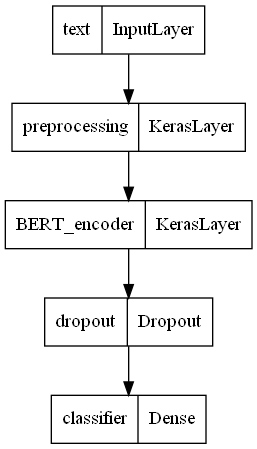

In [16]:
tf.keras.utils.plot_model(classifier_model)

Note: training time will vary depending on the complexity of the BERT model you have selected.

In [17]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=x_train, y=y_train,
                               validation_data=(x_valid, y_valid),
                               epochs=epochs, batch_size=mini_batch, class_weight={1:1, 0:5})

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Epoch 1/15


C:\Users\srandrad\Anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


19/19 [==============================] - 7s 190ms/step - loss: 1.3214 - binary_accuracy: 0.4615 - precision: 0.8279 - recall: 0.4191 - f1_m: 0.5473 - val_loss: 0.5985 - val_binary_accuracy: 0.6869 - val_precision: 0.9492 - val_recall: 0.6667 - val_f1_m: 0.7511
Epoch 2/15
19/19 [==============================] - 3s 167ms/step - loss: 1.1171 - binary_accuracy: 0.5987 - precision: 0.8854 - recall: 0.5768 - f1_m: 0.6823 - val_loss: 0.4849 - val_binary_accuracy: 0.8788 - val_precision: 0.9390 - val_recall: 0.9167 - val_f1_m: 0.9075
Epoch 3/15
19/19 [==============================] - 3s 163ms/step - loss: 1.0093 - binary_accuracy: 0.7090 - precision: 0.9326 - recall: 0.6888 - f1_m: 0.7800 - val_loss: 0.4732 - val_binary_accuracy: 0.8485 - val_precision: 0.9859 - val_recall: 0.8333 - val_f1_m: 0.8407
Epoch 4/15
19/19 [==============================] - 3s 162ms/step - loss: 0.8940 - binary_accuracy: 0.7492 - precision: 0.9511 - recall: 0.7261 - f1_m: 0.8178 - val_loss: 0.3925 - val_binary_accu

### Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents the error, lower values are better), and accuracy.

In [18]:
valid_pred = np.round(classifier_model.predict(x_valid))
train_pred = np.round(classifier_model.predict(x_train))

In [19]:
print(classification_report(y_train, train_pred))

              precision    recall  f1-score   support

           0       0.88      0.98      0.93        58
           1       1.00      0.97      0.98       241

    accuracy                           0.97       299
   macro avg       0.94      0.97      0.95       299
weighted avg       0.97      0.97      0.97       299



In [20]:
print(classification_report(y_valid, valid_pred))

              precision    recall  f1-score   support

           0       0.55      0.73      0.63        15
           1       0.95      0.89      0.92        84

    accuracy                           0.87        99
   macro avg       0.75      0.81      0.77        99
weighted avg       0.89      0.87      0.88        99



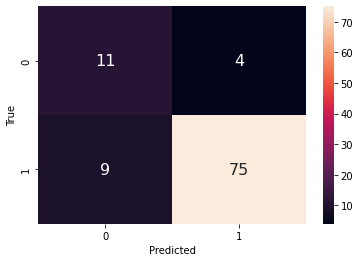

In [21]:
cm = confusion_matrix(y_valid, valid_pred)#, normalize='true')  
sns.heatmap(cm, annot=True, annot_kws={"size": 16})
plt.ylabel("True")
plt.xlabel("Predicted")
plt.show()

### Plot the accuracy and loss over time

Based on the `History` object returned by `model.fit()`. You can plot the training and validation loss for comparison, as well as the training and validation accuracy:

dict_keys(['loss', 'binary_accuracy', 'precision', 'recall', 'f1_m', 'val_loss', 'val_binary_accuracy', 'val_precision', 'val_recall', 'val_f1_m'])


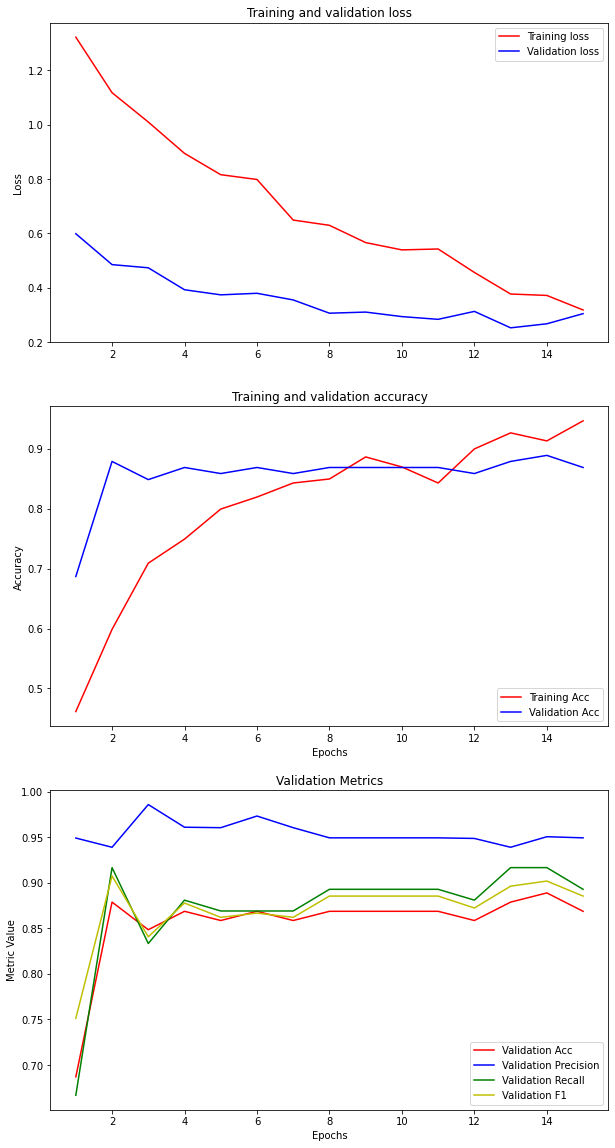

In [22]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
pre = history_dict['precision']
val_pre = history_dict['val_precision']
recall = history_dict['recall']
val_recall = history_dict['val_recall']
f1 = history_dict['f1_m']
val_f1 = history_dict['val_f1_m']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 20))
fig.tight_layout()

plt.subplot(3, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(epochs, acc, 'r', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
# plt.plot(epochs, pre, 'b', label='Training Precision')
# plt.plot(epochs, val_pre, 'b', linestyle='dashed', label='Validation Precision')
# plt.plot(epochs, recall, 'g', label='Training Recall')
# plt.plot(epochs, val_recall, 'g', linestyle='dashed', label='Validation Recall')
# plt.plot(epochs, f1, 'y', label='Training F1')
# plt.plot(epochs, val_f1, 'y', linestyle='dashed', label='Validation F1')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(3, 1, 3)
#plt.plot(epochs, acc, 'r', label='Training Acc')
plt.plot(epochs, val_acc, 'r', label='Validation Acc')
# plt.plot(epochs, pre, 'b', label='Training Precision')
plt.plot(epochs, val_pre, 'b', label='Validation Precision')
# plt.plot(epochs, recall, 'g', label='Training Recall')
plt.plot(epochs, val_recall, 'g', label='Validation Recall')
# plt.plot(epochs, f1, 'y', label='Training F1')
plt.plot(epochs, val_f1, 'y', label='Validation F1')
plt.title('Validation Metrics')
plt.xlabel('Epochs')
plt.ylabel('Metric Value')
plt.legend(loc='lower right')

In this plot, the red lines represent the training loss and accuracy, and the blue lines are the validation loss and accuracy.

## Export for inference

Now you just save your fine-tuned model for later use.

In [23]:
# dataset_name = 'llis'
# saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

# classifier_model.save(saved_model_path, include_optimizer=False)

Let's reload the model, so you can try it side by side with the model that is still in memory.

In [24]:
# reloaded_model = tf.saved_model.load(saved_model_path)

## Next: class imbalances
- weighted loss function
- down sampling of majority class in training data